In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.reset_option('display.float_format', silent=True)
nft_trades = pd.read_csv('nft_traders_flipside.csv')
nft_trades['avg_nb_hours_between_hold_trade'] = nft_trades['avg_nb_minutes_between_hold_trade'] /60
nft_trades.drop(['X__row_index','avg_nb_minutes_between_hold_trade'],axis=1,inplace=True)
nft_trades.dropna(inplace=True)

In [3]:
features = ['total_sol_amount_traded', 'total_trade_count', 'unique_nft_traded', 'total_buys', 'total_sells', 'nb_days_since_first_trade', 'avg_nb_minutes_between_trades','avg_nb_hours_between_hold_trade']
X = nft_trades[features].values

In [4]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [5]:
n_clusters = 7
kmeans = KMeans(n_clusters,random_state=42)
kmeans.fit(scaled_features)
clusters = kmeans.labels_
nft_trades['Cluster'] = kmeans.labels_

In [6]:
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(scaled_features)
scores = iso_forest.decision_function(scaled_features) 

nft_trades['AnomalyScore'] = iso_forest.decision_function(scaled_features)
nft_trades['AnomalyScore'] = nft_trades['AnomalyScore'] - nft_trades['AnomalyScore'].min()

In [7]:
# Apply PCA to reduce dimensionality to  2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

In [8]:

mean_df = nft_trades.groupby('Cluster')[features].mean().reset_index()

count_df = nft_trades.groupby('Cluster').size().reset_index(name='count')

cluster_summary = pd.merge(count_df, mean_df, on='Cluster')
cluster_summary

,Cluster,count,total_sol_amount_traded,total_trade_count,unique_nft_traded,total_buys,total_sells,nb_days_since_first_trade,avg_nb_minutes_between_trades,avg_nb_hours_between_hold_trade
0,0,213891,60.798287,27.732621,17.842551,14.368604,13.364017,27.692152,15377.193668,467.862056
1,1,70396,485.603635,142.985823,102.600787,76.357989,66.627834,325.828470,30553.702303,2245.363351
2,2,20,34635.341272,37624.650000,17416.000000,19877.750000,17746.900000,197.550000,8.818936,100.812857
3,3,30856,19.458673,9.733245,9.487847,1.996370,7.736875,79.227573,78131.582684,10207.285983
4,4,10614,5.376080,1.242793,1.201809,0.080366,1.162427,15.885623,613976.873846,8268.806952
5,5,245,22390.776764,8760.946939,4813.657143,4671.706122,4089.240816,257.053061,66.611507,265.554498
6,6,1,19191.565755,141146.000000,84075.000000,77861.000000,63285.000000,420.000000,4.295028,375.114353


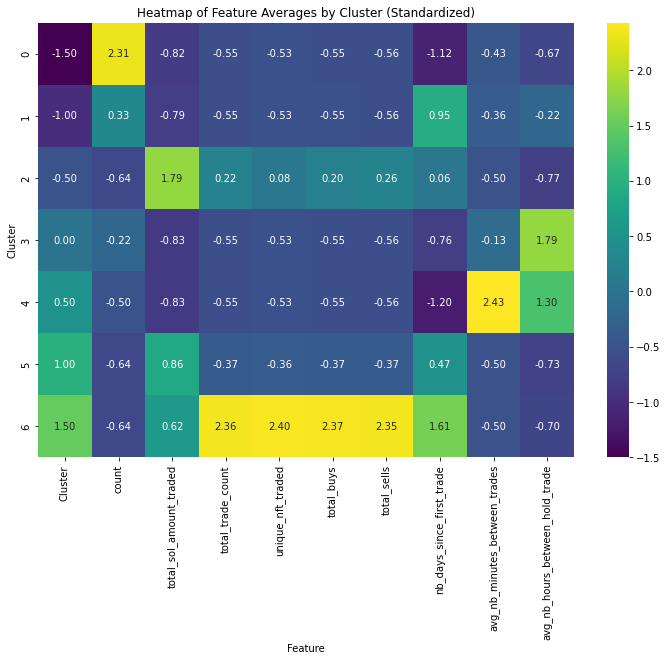

In [9]:
scaler = StandardScaler()
scaled_cluster_means = scaler.fit_transform(cluster_summary)
scaled_cluster_means_df = pd.DataFrame(scaled_cluster_means, index=cluster_summary.index, columns=cluster_summary.columns)

# Visualize using heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(scaled_cluster_means_df, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Feature Averages by Cluster (Standardized)')
plt.ylabel('Cluster')
plt.xlabel('Feature')
plt.show()

In [10]:
nft_trades_clustered = nft_trades[nft_trades['Cluster']==1].reset_index(drop=True)
nft_trades_clustered.to_csv('nft_traders_classified.csv',index=False)
